In [2]:
import pandas as pd
import os
import datetime as dt
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('bmh') 


pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
import mlflow

remote_server_uri = "databricks" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("/my-experiment")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/173139626917049', experiment_id='173139626917049', lifecycle_stage='active', name='/my-experiment', tags={'mlflow.experiment.sourceName': '/my-experiment',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'shivanshug14+unsub@gmail.com',
 'mlflow.ownerId': '3176862807905950'}>

In [4]:
data_path = '/Users/sg/projects/EDS-I-Group-Project/data'

In [5]:
df = pd.read_csv(f'{data_path}/family_stores_unit_sales.csv')

In [6]:
df.head()

,family,store_nbr,year_week,unit_sales,type
0,BEVERAGES,10,201301,4349.000,C
1,BEVERAGES,10,201302,3126.000,C
2,BEVERAGES,10,201303,3001.000,C
3,BEVERAGES,10,201304,2895.000,C
4,BEVERAGES,10,201305,3037.000,C


In [7]:
# keep only type A store and only columns used for analysis
df = df[df.type == 'A'][['family', 'year_week', 'unit_sales']].copy().reset_index(drop=True)

In [8]:
#generate a datetime column based on the year_week column. We define the format so pandas knows we used week number
df['date'] = pd.to_datetime(df.year_week.apply(lambda x: str(x) + '0'), format = '%Y%W%w')

df = df[[ 'date','family' ,'unit_sales']] # work with the datetime column from now on

In [9]:
# filter to have only until the last complete month in the data, which is July
df = df[(df.date <= '2017-07-01') ]
df.date.max()

Timestamp('2017-06-25 00:00:00')

In [10]:
# reshape the table to make analysis easier: one column per family
df_ts = pd.pivot_table(df, 
               values='unit_sales',
               index='date', 
               columns = 'family'
          ).fillna(0)

In [11]:
df_ts = df_ts.asfreq('W') # we define the sampling frequency as weekly, this will help with the visuals 

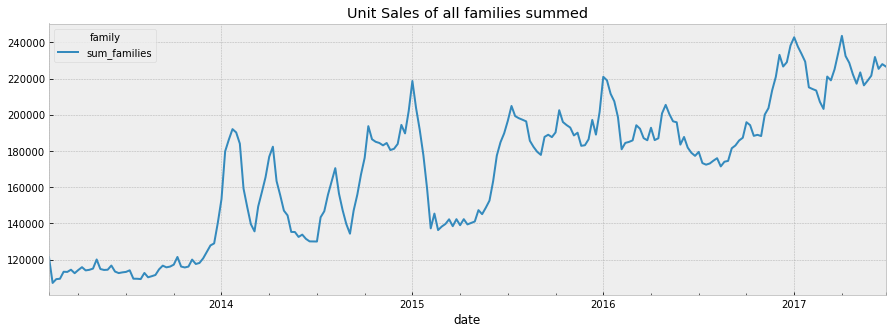

In [12]:
fig, ax = plt.subplots(figsize = (13,5))


df_ts['sum_families']= df_ts.sum(axis=1) # a TOTALS column to sum all families
df_ts_smoothed = df_ts.rolling(5).mean().dropna() # we create a smoothed df for visuals
df_ts_smoothed[['sum_families']].plot(figsize= (15,5), ax=ax)
plt.title('Unit Sales of all families summed')
plt.show()



In [13]:
df_ts_smoothed = df_ts_smoothed.drop(columns = 'sum_families')

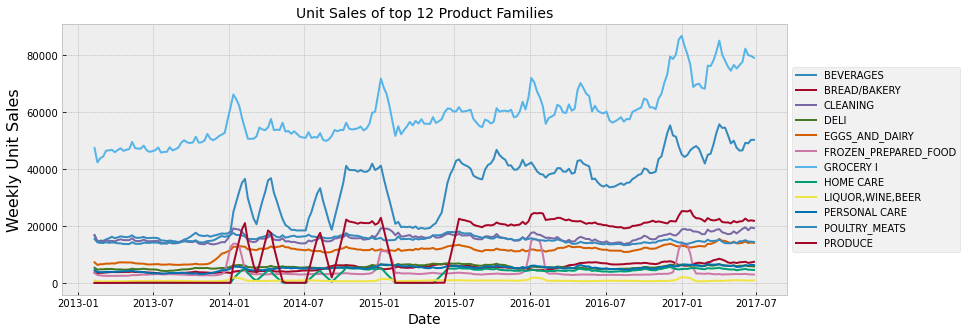

In [14]:
fig, ax = plt.subplots(figsize = (13,5))

for fam in df_ts_smoothed.columns:
    sns.lineplot( ax = ax , data =  df_ts_smoothed, x = df_ts_smoothed.index, y =  df_ts_smoothed[fam], label = fam)
    
plt.ylabel('Weekly Unit Sales', size=16)
plt.xlabel('Date', size=14)
plt.legend()
plt.title('Unit Sales of top 12 Product Families', size=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
! pip install darts
from IPython.display import clear_output
clear_output()

In [17]:
from darts import TimeSeries
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np


df_ts = df_ts.drop(['sum_families'], axis=1, errors = 'ignore')
eigvals = coint_johansen(df_ts,-1,1).eig

if np.where(eigvals > 0.99, 1, 0).sum() == 0:
    print('Data is stationary')
    data_stationary = True

Data is stationary


- First we try with a single series: Beverages

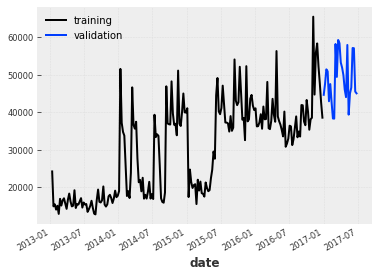

In [18]:
series = TimeSeries.from_series(df_ts.BEVERAGES)

train, val = series.split_before(pd.Timestamp("2017-01-01"))
train.plot(label="training")
val.plot(label="validation")

# the red part is the one we want to predict (2017 onwards)

In [26]:
# try different techniques to predict
from darts.models import ExponentialSmoothing, AutoARIMA, Theta, NaiveSeasonal
from darts.metrics import mape

def eval_model(model, model_name):
    with mlflow.start_run(run_name=model_name):
        model.fit(train)
        forecast = model.predict(len(val))
        model_mape = mape(val, forecast)
        print("model {} obtains MAPE: {:.2f}%".format(model, model_mape))
        mlflow.log_metric("MAPE", model_mape/100)
        mlflow.sklearn.log_model(model, model_name)


eval_model(ExponentialSmoothing(), 'Unit_Sales_Forecasting_Store_A_ExpoSmoothing')
eval_model(AutoARIMA(), 'Unit_Sales_Forecasting_Store_A_AutoARIMA')
eval_model(NaiveSeasonal(K=52), 'Unit_Sales_Forecasting_Store_A_NaiveSeasonal')


/Users/sg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=52 obtains MAPE: 22.99%
model Auto-ARIMA obtains MAPE: 12.30%
model Naive seasonal model, with K=52 obtains MAPE: 6.85%


model Auto-ARIMA obtains MAPE: 12.30%


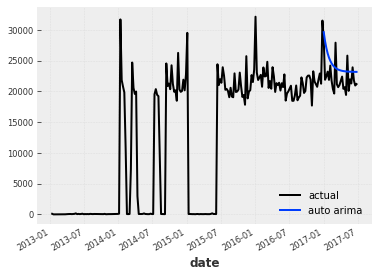

In [27]:
# use Auto ARIMA best performer
model = AutoARIMA()
model.fit(train),
model_forecast = model.predict(len(val))

series.plot(label="actual")
model_forecast.plot(label="auto arima")

forecast = model.predict(len(val))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

- Now lets repeat for all families, one by one to have all the plots

In [ ]:
df_ts = df_ts.drop(columns = ['sum_families'])

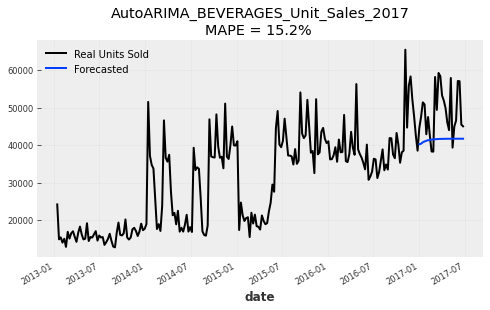

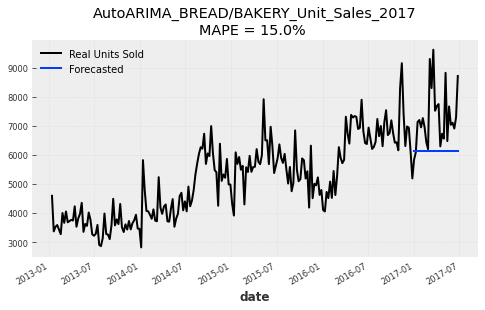

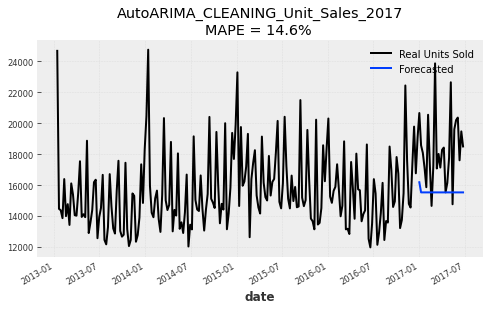

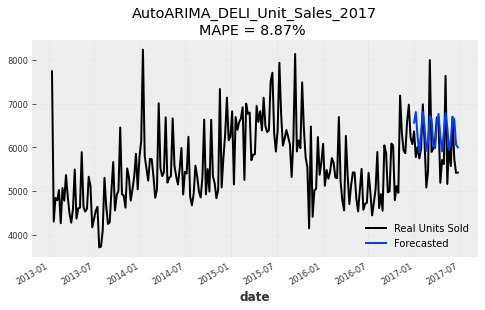

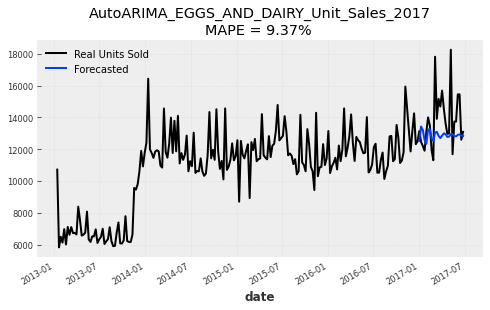

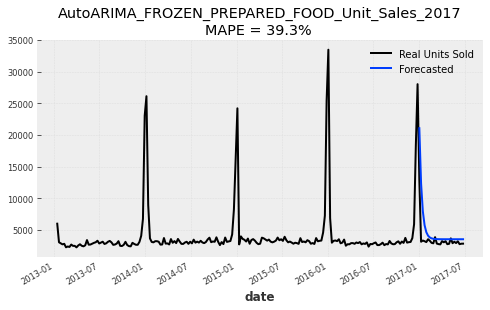

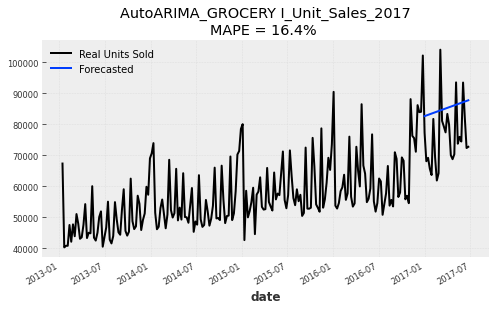

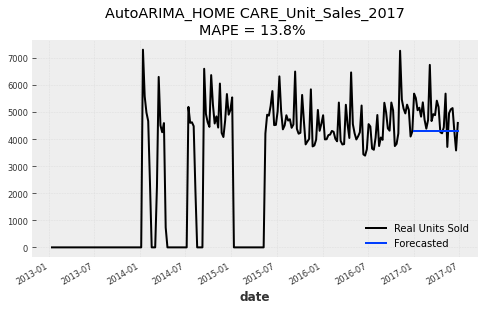

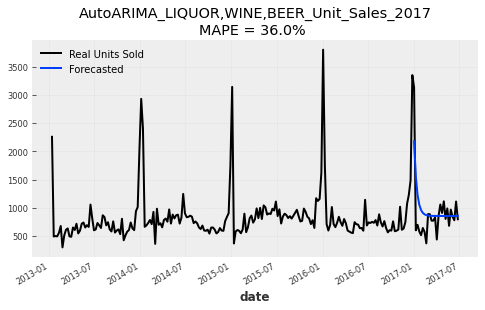

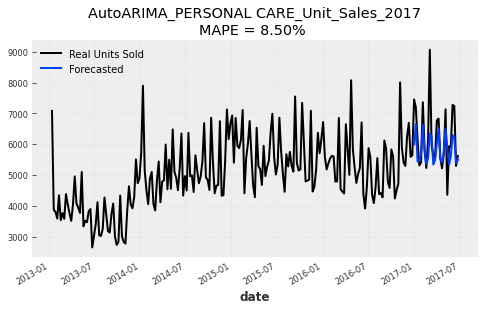

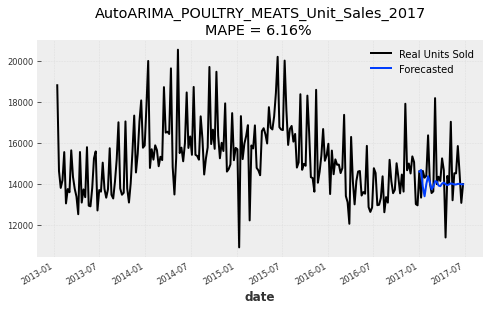

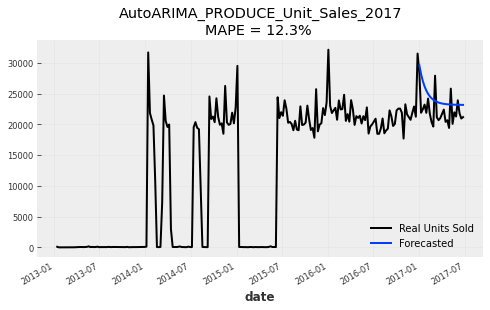

In [29]:
mapes = []

from darts.metrics import mape

for fam in df_ts.columns.to_list():
    model_name = f'AutoARIMA_{fam}_Unit_Sales_2017'
    series = TimeSeries.from_series(df_ts[fam])
    train, val = series.split_before(pd.Timestamp("2017-01-01"))

    #train model and get predictions
    with mlflow.start_run(run_name=model_name):
        model = AutoARIMA()
        model.fit(train),
        model_forecast = model.predict(len(val))
        mape_score = mape(val, model_forecast)
        mlflow.log_metric("MAPE", mape_score/100)
        mlflow.sklearn.log_model(model, model_name)

    #plot predictions with all annotations
    f,ax = plt.subplots(figsize=(8,4))
    series.plot(label=f"Real Units Sold", ax= ax)
    model_forecast.plot(label="Forecasted", ax=ax)
    plt.title(f'{model_name}\nMAPE = {str(mape_score)[:4]}% ')
    
    plt.show()
    
    # append mape score

    mapes.append(mape_score)

In [30]:
df_results = pd.DataFrame(np.vstack([df_ts.columns, mapes]).T, columns = ['Family', 'AutoARIMA MAPE'])

<AxesSubplot:ylabel='Family'>

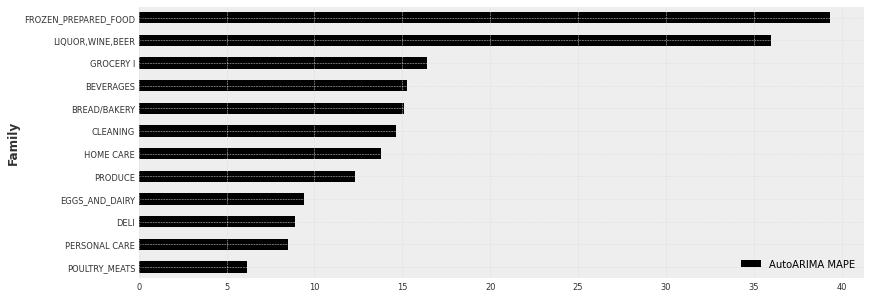

In [31]:
df_results.sort_values(by= 'AutoARIMA MAPE').reset_index(drop=True).set_index('Family').plot(kind='barh', figsize = (13,5))